In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
sys.path.append("../Scripts")

from data_cleaning import clean_prices, audit_data_quality
from compute_returns import compute_daily_returns, compute_mu_and_cov, save_outputs

# Create output directories
os.makedirs("../Results/processed", exist_ok=True)
os.makedirs("../Results/plots", exist_ok=True)


In [ ]:
print("=" * 70)
print("STEP 1: LOADING RAW DATA")
print("=" * 70)

df = pd.read_csv("../Dataset/all_stocks_5yr.csv")
print(f"Loaded {len(df)} rows")
print(f"\nFirst 5 rows:")
print(df.head())

,date,Name,open,high,low,close,volume
71611,2013-02-08,A,45.07,45.35,45.00,45.08,1824755
71612,2013-02-11,A,45.17,45.18,44.45,44.60,2915405
71613,2013-02-12,A,44.81,44.95,44.50,44.62,2373731
71614,2013-02-13,A,44.81,45.24,44.68,44.75,2052338
71615,2013-02-14,A,44.72,44.78,44.36,44.58,3826245


In [ ]:
print("\n" + "=" * 70)
print("STEP 2: EXPLORATORY DATA ANALYSIS")
print("=" * 70)

# Dataset shape
print(f"\nDataset Shape: {df.shape}")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Column data types
print("\nColumn Data Types:")
print(df.info())

# Check for null values
print("\nNull Values per Column:")
print(df.isnull().sum())
print(f"Total null values: {df.isnull().sum().sum()}")

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Check for negative values
print("\nNegative Values Check:")
for column in df.select_dtypes(include=np.number).columns:
    neg_count = df[column][df[column] < 0].count()
    if neg_count > 0:
        print(f"  {column}: {neg_count} negative values")
    else:
        print(f"  {column}: ✔ No negative values")

# Summary statistics
print("\nSummary Statistics:")
print(df.describe())

(468, ['A', 'AAL', 'AAP', 'AAPL', 'ABBV'])

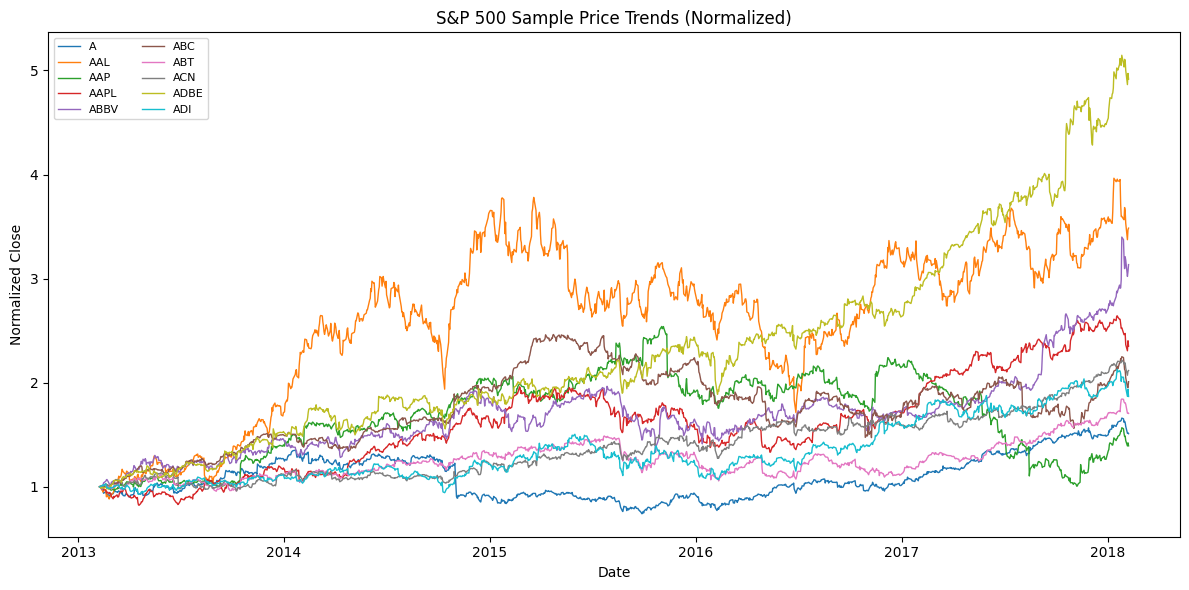

In [ ]:
print("\n" + "=" * 70)
print("STEP 3: DATA QUALITY AUDIT")
print("=" * 70)

# Convert date for audit
df_temp = df.copy()
df_temp["date"] = pd.to_datetime(df_temp["date"])

# Run comprehensive audit
audit_results = audit_data_quality(df_temp, verbose=True)

print("\nAudit Summary:")
print(f"  - Rows with Low > High: {audit_results['low_gt_high']}")
print(f"  - Rows with Bad Volume: {audit_results['bad_volume']}")
print(f"  - Rows with Bad Price: {audit_results['bad_price']}")

In [ ]:
print("\n" + "=" * 70)
print("STEP 4: OUTLIER DETECTION")
print("=" * 70)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Boxplots for Outlier Detection (Raw Data)', fontsize=16)

numeric_cols = ['open', 'high', 'low', 'close', 'volume']
for idx, column in enumerate(numeric_cols):
    row = idx // 3
    col = idx % 3
    axes[row, col].boxplot(df[column].dropna())
    axes[row, col].set_title(f'{column}')
    axes[row, col].set_ylabel('Value')

# Hide the extra subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig("../Results/plots/outliers_raw_data.png", dpi=150)
plt.show()

print("Outlier plots saved to ../Results/plots/outliers_raw_data.png")

In [ ]:
print("\n" + "=" * 70)
print("STEP 5: DATA CLEANING")
print("=" * 70)

df["date"] = pd.to_datetime(df["date"])
df_clean = clean_prices(df, verbose=True)

print("\nCleaned Data Sample:")
print(df_clean.head())

# Save cleaned data
df_clean.to_csv("../Results/processed/data_cleaned.csv", index=False)
print("\n✓ Saved cleaned data to ../Results/processed/data_cleaned.csv")

In [ ]:
print("\n" + "=" * 70)
print("STEP 6: POST-CLEANING ANALYSIS")
print("=" * 70)

print(f"\nUnique tickers: {df_clean['ticker'].nunique()}")
print(f"Date range: {df_clean['date'].min()} to {df_clean['date'].max()}")
print(f"Total trading days: {df_clean['date'].nunique()}")

# Stocks with most data points
print("\nTop 10 stocks by data points:")
top_stocks = df_clean['ticker'].value_counts().head(10)
print(top_stocks)

In [ ]:
print("\n" + "=" * 70)
print("STEP 7: COMPUTING RETURNS AND STATISTICS")
print("=" * 70)

df_returns = compute_daily_returns(df_clean)
print(f"Computed returns for {len(df_returns)} data points")

mu, cov, tickers = compute_mu_and_cov(df_returns)
save_outputs(mu, cov, tickers)

print(f"\nNumber of tickers: {len(tickers)}")
print(f"Expected returns (μ) - first 5 stocks:")
for i in range(min(5, len(tickers))):
    print(f"  {tickers[i]}: {mu[i]:.6f}")

print(f"\nCovariance matrix shape: {cov.shape}")

In [ ]:
print("\n" + "=" * 70)
print("STEP 8: CREATING VISUALIZATIONS")
print("=" * 70)

# Plot 1: Sample Price Trends (Normalized)
plt.figure(figsize=(14, 7))
sample_tickers = tickers[:10]  # first 10 tickers

for name, sub in df_clean[df_clean["ticker"].isin(sample_tickers)].groupby("ticker"):
    s = sub.sort_values("date")
    # Normalize to start at 1.0
    norm = s["close"] / s["close"].iloc[0]
    plt.plot(s["date"], norm, label=name, linewidth=1.5, alpha=0.8)

plt.title("S&P 500 Sample Price Trends (Normalized to Starting Price)", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Normalized Close Price", fontsize=12)
plt.legend(ncol=2, fontsize=9, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../Results/plots/S&P_price_trends.png", dpi=150)
plt.show()

print("✓ Saved price trends plot")

# Plot 2: Volume Distribution
plt.figure(figsize=(12, 6))
plt.hist(df_clean['volume'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Trading Volume (Cleaned Data)', fontsize=14, fontweight='bold')
plt.xlabel('Volume', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.yscale('log')  # Log scale for better visibility
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../Results/plots/volume_distribution.png", dpi=150)
plt.show()

print("✓ Saved volume distribution plot")

# Plot 3: Returns Distribution
plt.figure(figsize=(12, 6))
all_returns = df_returns.dropna()['return'].values
plt.hist(all_returns, bins=100, edgecolor='black', alpha=0.7)
plt.title('Distribution of Daily Returns', fontsize=14, fontweight='bold')
plt.xlabel('Daily Return', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../Results/plots/returns_distribution.png", dpi=150)
plt.show()

print("✓ Saved returns distribution plot")

In [ ]:
print("\n" + "=" * 70)
print("FINAL SUMMARY REPORT")
print("=" * 70)

print(f"""
Data Processing Complete!

Raw Data:
  - Total rows: {len(df)}
  - Columns: {len(df.columns)}

Cleaned Data:
  - Total rows: {len(df_clean)}
  - Rows removed: {len(df) - len(df_clean)} ({100*(len(df) - len(df_clean))/len(df):.2f}%)
  - Unique tickers: {df_clean['ticker'].nunique()}
  - Date range: {df_clean['date'].min().date()} to {df_clean['date'].max().date()}

Quality Checks:
  - No missing values: {df_clean.isnull().sum().sum() == 0}
  - No logical errors (low > high): {len(df_clean[df_clean['low'] > df_clean['high']]) == 0}
  - No invalid volumes: {len(df_clean[df_clean['volume'] <= 0]) == 0}
  - No invalid prices: {len(df_clean[df_clean['close'] <= 0]) == 0}

Outputs Saved:
  ✓ ../Results/processed/data_cleaned.csv
  ✓ ../Results/processed/mu.npy
  ✓ ../Results/processed/cov.npy
  ✓ ../Results/processed/tickers.txt
  ✓ ../Results/plots/S&P_price_trends.png
  ✓ ../Results/plots/outliers_raw_data.png
  ✓ ../Results/plots/volume_distribution.png
  ✓ ../Results/plots/returns_distribution.png
""")

print("=" * 70)
print("PROCESSING COMPLETE!")
print("=" * 70)